In [1]:
from __future__ import division, print_function

import copy
import os
import random
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

from cub_dataloader_good import CUB, denormalize, normalize, visualize

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [2]:
data = './CUB_200_2011/'
num_classes = 200
num_epochs = 30

feature_extract = True

batch_size = 8

In [3]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [4]:
# Load the pretrained model
resnet = models.resnet101(pretrained=True)

# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')

# Set the model to evaluation mode
resnet.eval()

/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
def normalize():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

def show_image(img):
  img = img.transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)

In [6]:
# Define the image transformations - normalization based on ImageNet parameters
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    normalize(),
    transforms.ToTensor(),
])

In [7]:
PATH = Path('./CUB_200_2011/CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [8]:
train_classes = pd.read_csv("./xlsa17/data/CUB/trainvalclasses.txt", header=None, sep=".")
test_classes = pd.read_csv("./xlsa17/data/CUB/testclasses.txt", header=None, sep=".")
image_class_labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")

train_images = images.merge(image_class_labels, on=0, how="inner").merge(train_classes, how="inner", left_on='1_y', right_on=0)
train_images['is_train'] = 1
test_images = images.merge(image_class_labels, on=0, how="inner").merge(test_classes, how="inner", left_on='1_y', right_on=0)
test_images['is_train'] = 0

# combine train and test images
train_test = pd.concat([train_images, test_images], axis=0)
train_test.drop(train_test.columns[1:5], axis=1, inplace=True)
train_test.columns = ["id", "is_train"]
train_test = train_test.sort_values(by='id')
train_test = train_test.reset_index(drop=True)

In [9]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [10]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [11]:
categories = [x for x in classes["class"]]

In [12]:
# attributes = pd.read_csv(
#     PATH/"attributes/image_attribute_labels.txt", 
#     header=None, 
#     delim_whitespace=True, 
#     on_bad_lines=lambda x: [x[0], x[1], x[2], x[3], "-1"], 
#     engine='python'
# )
# attributes.drop(attributes.columns[3:], axis=1, inplace=True)
# attributes.columns = ["id", "attribute", "is_present"]

class_attributes = pd.read_csv(PATH/"attributes/class_attribute_labels_continuous.txt", header=None, sep=" ")

In [13]:
from pathlib import Path

PATH = Path('./CUB_200_2011/CUB_200_2011')

train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform= False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

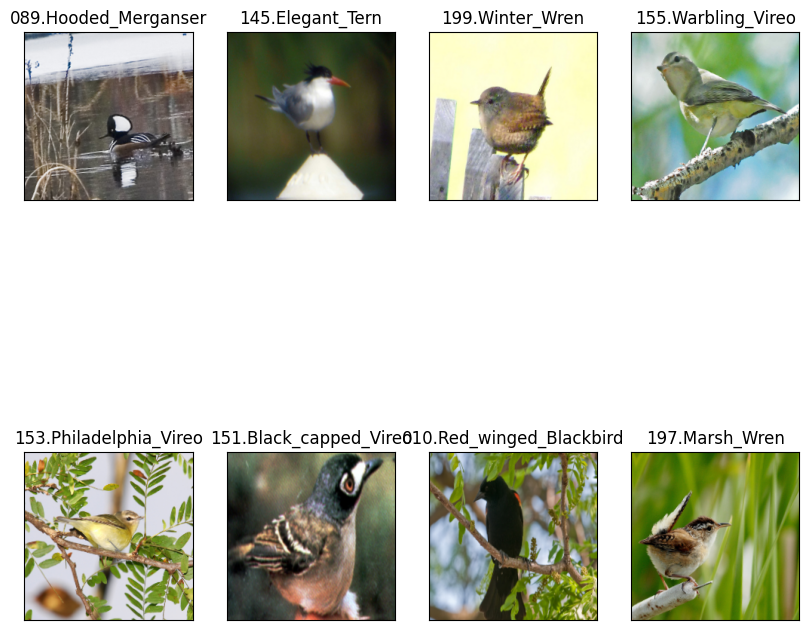

In [14]:
visualize(train_loader, categories)

In [15]:
# Load the pretrained model
resnet = models.resnet101(pretrained=True)
resnet.to(device)

layer = resnet._modules.get('avgpool')

/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def get_vector(img):
    img = image_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    my_embedding = torch.zeros(2048)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    h = layer.register_forward_hook(copy_data)
    resnet(img)
    h.remove()
    return my_embedding

# get_vector implementation that works with batches
# imgs is a tensor of shape (batch_size, 3, 224, 224) 
def get_vectors(imgs):
    imgs = imgs.to(device)
    my_embeddings = torch.zeros(imgs.shape[0], 2048)
    def copy_data(m, i, o):
        my_embeddings.copy_(o.data.squeeze())
    h = layer.register_forward_hook(copy_data)
    resnet(imgs)
    h.remove()
    return my_embeddings

Image: tensor([[[ 0.4166,  0.4166,  0.4337,  ...,  0.6563,  0.6563,  0.6734],
         [ 0.3994,  0.4166,  0.3823,  ...,  0.7077,  0.6906,  0.7077],
         [ 0.3994,  0.3994,  0.3652,  ...,  0.7248,  0.7077,  0.7248],
         ...,
         [ 0.2453,  0.2453,  0.2967,  ...,  0.0569,  0.0227, -0.0116],
         [ 0.1768,  0.1768,  0.1597,  ...,  0.0398,  0.0227,  0.0227],
         [ 0.1254,  0.1254,  0.0912,  ...,  0.0056, -0.0287,  0.0227]],

        [[ 0.6429,  0.5903,  0.5553,  ...,  0.5553,  0.5553,  0.5728],
         [ 0.6254,  0.6078,  0.5378,  ...,  0.6254,  0.5903,  0.6078],
         [ 0.6254,  0.5903,  0.5203,  ...,  0.6429,  0.6429,  0.6254],
         ...,
         [ 0.8704,  0.8704,  0.9405,  ...,  0.3627,  0.4153,  0.3978],
         [ 0.7129,  0.6954,  0.7129,  ...,  0.4503,  0.4153,  0.3978],
         [ 0.5553,  0.5553,  0.5203,  ...,  0.4503,  0.3978,  0.3627]],

        [[ 0.2522,  0.2173,  0.2348,  ...,  0.5485,  0.5834,  0.6182],
         [ 0.2696,  0.2522,  0.2173,  

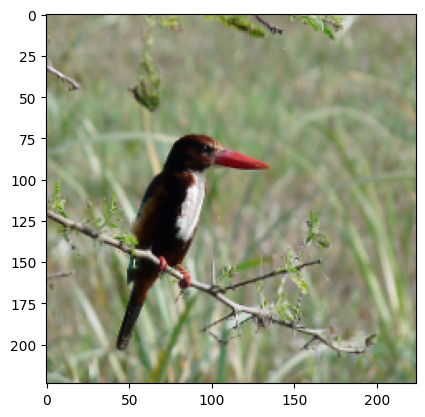

In [17]:
x, y = next(iter(train_loader))
single_image = x[0]
single_label = y[0]

print(f"Image: {single_image}")
print(f"Image shape: {single_image.shape}")
print(f"Label: {single_label}")

inp = single_image.numpy().transpose(1,2,0)
inp = denormalize(inp)
plt.imshow(inp)


single_image.unsqueeze_(0)

# Make sure the image tensor is on the same device as the model
single_image = single_image.to(next(resnet.parameters()).device)

# Make sure image dtype is the same as model's expected input
single_image = single_image.float()

# Set the model to evaluation mode
resnet.eval()

# Apply the model to the image
output = resnet(single_image)

# Get the index corresponding to the maximum score and the maximum score itself.
_, pred = torch.max(output.data, 1)
print(f"Predicted class index: {pred.item()}")
print(f"Predicted class: {categories[pred.item()]}")
print(f"Actual class label: {categories[single_label]}")

print(type(output))
print(output)
print(output.data.shape)

In [18]:
N_TRAIN_CLASSES = len(train_classes)
N_CLASSES = len(train_classes) + len(test_classes)
N = N_TRAIN_CLASSES

In [19]:
# Implement SE-GZSL networks
# Implement semantic encoder
def make_semantic_encoder():
    return nn.Sequential(
        nn.Linear(2048, 4096),
        nn.LeakyReLU(0.02)
    )

def make_residual_encoder():
    return nn.Sequential(
        nn.Linear(2048, 4096),
        nn.LeakyReLU(0.02)
    )

def make_decoder():
    return nn.Sequential(
        nn.Linear(4096*2, 2048),
        nn.ReLU()
    )

def make_classifier():
    return nn.Sequential(
        nn.Linear(4096, N_CLASSES),
        nn.LogSoftmax(dim=1)
    )

# Implement generator
def make_generator():
    # ? how to get the noise vector in here?
    return nn.Sequential(
        nn.Linear(312, 2048),
        nn.ReLU(),
    )

# Implement critic
def make_critic():
    return nn.Sequential(
        nn.Linear(4096, 1),
        nn.LeakyReLU(0.02)
    )


In [20]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(list_1, list_2):
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
  return cos_sim

def similiarity_loss(semantic_encoder_outputs):
  # semantic encoder outputs is a list of [tensor[4096], tensor[1]] pairs
  # the first element represents the semantic encoder output, the second element the class label
  # we want to maximize the cosine similarity between semantic encoder outputs of the same class
  # while minimizing the cosine similarity between semantic encoder outputs of different classes

  # first, we need to group the semantic encoder outputs by class
  # we can do this by creating a dictionary with the class label as key and a list of semantic encoder outputs as value
  # we can then iterate over the dictionary and calculate the cosine similarity between all pairs of semantic encoder outputs
  # we can then take the mean of the cosine similarities between all pairs of semantic encoder outputs of the same class
  # and the mean of the cosine similarities between all pairs of semantic encoder outputs of different classes
  # and return the difference between the two means as the loss

  # create dictionary with class label as key and list of semantic encoder outputs as value
  cos_similarity = torch.nn.CosineSimilarity(dim=0)

  semantic_encoder_outputs_dict = {}
  for semantic_encoder_output in semantic_encoder_outputs:
    class_label = semantic_encoder_output[1]
    if class_label in semantic_encoder_outputs_dict:
      semantic_encoder_outputs_dict[class_label].append(semantic_encoder_output[0])
    else:
      semantic_encoder_outputs_dict[class_label] = [semantic_encoder_output[0]]
  
  similiarity_loss = 0
  for label, outputs in semantic_encoder_outputs_dict.items():
    same_class_similarity = 0
    different_class_similarity = 0

    for z_i in outputs:
      # calculate same class similarity
      for z_j in outputs:
        # skip same element
        if torch.equal(z_i, z_j):
          continue

        cos_sim = cos_similarity(z_i, z_j)
        same_class_similarity += torch.exp(cos_sim)

      # calculate different class similarity
      for label_prime, outputs_prime in semantic_encoder_outputs_dict.items():
        # skip same class
        if label_prime == label:
          continue

        for z_j_prime in outputs:
          cos_sim = cos_similarity(z_i, z_j_prime)
          different_class_similarity += torch.exp(cos_sim)

    similiarity_loss += torch.log(torch.div(same_class_similarity, different_class_similarity))
  
  return np.divide(similiarity_loss, len(train_loader))

In [21]:
from mi_estimators import CLUB, CLUBForCategorical, InfoNCE

def mi_loss(semantic_output, residual_output, labels):
    # print(f"output.shape: {output.shape}")
    # print(f"target.shape: {target.shape}")

    # labels has shape [32] and contains the class label ids for each image in the batch
    # class_attributes has shape [200, 312] and contains the class attributes for each class
    # class_attributes[labels] has shape [32, 312] and contains the class attributes for each image in the batch
    cuda_class_attributes = torch.from_numpy(class_attributes.to_numpy()).to(device)
    batch_class_attributes = cuda_class_attributes[labels].to(torch.float32)

    lambda_s = 0.1 # TODO: tune
    lambda_r = 0.1 # TODO: tune
    # InfoNCE takes x_dim, y_dim and hidden_size
    info_nce = InfoNCE(4096, 1, 4096).to(device)
    club = CLUBForCategorical(4096, 312, 4096).to(device)
    semantic_mi_loss = -lambda_s * info_nce(semantic_output, batch_class_attributes)
    residual_mi_loss = lambda_r * club(residual_output, batch_class_attributes)
    return semantic_mi_loss + residual_mi_loss

In [22]:
def total_loss(reconstructed_image_features, semantic_outputs, residual_output, labels):
    loss = 0
    # loss = mi_loss(semantic_outputs, residual_output, labels) # + nn.NLLLoss()(output, target)
    loss += similiarity_loss(semantic_outputs)
    return 

In [23]:
import scipy.io
import numpy as np
mat = scipy.io.loadmat('./xlsa17/data/CUB/att_splits.mat')
mat = np.array(mat)

In [24]:
# implement custom model
class SE_GZSL(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.semantic_encoder = make_semantic_encoder()
        self.residual_encoder = make_residual_encoder()
        self.decoder = make_decoder()

    def forward(self, image_features):
        semantic_output = self.semantic_encoder(image_features)
        residual_output = self.residual_encoder(image_features)
        reconstructed_image_feature = self.decoder(torch.cat((semantic_output, residual_output), dim=1))
        return reconstructed_image_feature, semantic_output, residual_output

class Generator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.generator = make_generator()

    def forward(self, noise_vector, attribute_vector):
        generated_image_features = self.generator(torch.cat((noise_vector, attribute_vector), dim=1))
        return generated_image_features

class Critic(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.critic = make_critic()

    def forward(self, image_features):
        critic_output = self.critic(image_features)
        return critic_output
    
class Classifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.classifier = make_classifier()

    def forward(self, image_features):
        classifier_output = self.classifier(image_features)
        return classifier_output

In [25]:
# training loop for SE-GZSL

# Initialize the model for this run
se_gzsl = SE_GZSL()

# Print the model we just instantiated
print(se_gzsl)

# Send the model to GPU
se_gzsl = se_gzsl.to(device)

# initialize the optimizer
optimizer = optim.Adam(se_gzsl.parameters(), lr=0.001)

sem_out = None

for epoch in range(num_epochs):
    # initialize tensor that holds all semantic_output/label pairs
    semantic_outputs = []

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device).to(torch.float32)
        labels = labels.to(device)

        # print(images)
        # print(images.shape)
        # print(labels)
        # print(labels.shape)

        # extract image features using resnet
        image_features = get_vectors(images).to(device)

        # Forward pass
        reconstructed_image_features, semantic_output, residual_output = se_gzsl(image_features)
        reconstructed_image_features
        semantic_output = semantic_output
        residual_output

        # create pairs of semantic output and label and save them to a tensor
        for i in range(len(semantic_output)):
          semantic_outputs.append([semantic_output[i], labels[i]])

        # write the above in a more torchy way
        # semantic_outputs.append(torch.cat((semantic_output, labels), dim=1))


        # print(f"reconstructed_image_features.shape: {reconstructed_image_features.shape}")
    
    print('lossing')
    loss = total_loss(reconstructed_image_features, semantic_outputs, residual_output, labels) # + nn.NLLLoss()(semantic_output, labels) + nn.NLLLoss()(residual_output, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

SE_GZSL(
  (semantic_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
  )
  (residual_encoder): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8192, out_features=2048, bias=True)
    (1): ReLU()
  )
)
lossing


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 12.00 GiB total capacity; 11.15 GiB already allocated; 0 bytes free; 11.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [49]:
import gc
gc.collect()
torch.cuda.empty_cache()